In [169]:
import numpy as np
import matplotlib.pyplot as plt


In [170]:
from sklearn import datasets

iris = datasets.load_iris()
X = iris.data
y = iris.target
X,y

(array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5. , 3.6, 1.4, 0.2],
        [5.4, 3.9, 1.7, 0.4],
        [4.6, 3.4, 1.4, 0.3],
        [5. , 3.4, 1.5, 0.2],
        [4.4, 2.9, 1.4, 0.2],
        [4.9, 3.1, 1.5, 0.1],
        [5.4, 3.7, 1.5, 0.2],
        [4.8, 3.4, 1.6, 0.2],
        [4.8, 3. , 1.4, 0.1],
        [4.3, 3. , 1.1, 0.1],
        [5.8, 4. , 1.2, 0.2],
        [5.7, 4.4, 1.5, 0.4],
        [5.4, 3.9, 1.3, 0.4],
        [5.1, 3.5, 1.4, 0.3],
        [5.7, 3.8, 1.7, 0.3],
        [5.1, 3.8, 1.5, 0.3],
        [5.4, 3.4, 1.7, 0.2],
        [5.1, 3.7, 1.5, 0.4],
        [4.6, 3.6, 1. , 0.2],
        [5.1, 3.3, 1.7, 0.5],
        [4.8, 3.4, 1.9, 0.2],
        [5. , 3. , 1.6, 0.2],
        [5. , 3.4, 1.6, 0.4],
        [5.2, 3.5, 1.5, 0.2],
        [5.2, 3.4, 1.4, 0.2],
        [4.7, 3.2, 1.6, 0.2],
        [4.8, 3.1, 1.6, 0.2],
        [5.4, 3.4, 1.5, 0.4],
        [5.2, 4.1, 1.5, 0.1],
        [5

In [171]:
X.shape, y.shape

((150, 4), (150,))

In [172]:
#This MLP will contain 1 hidden layers with n_nodes for each layer.
from sklearn.model_selection import train_test_split

class MLP:
    def __init__(self, n_classes, epochs=50, eta=0.01,
                 n_nodes=30, seed=1234, minibatch_size=1, l2=0,
                 shuffle=True):
        
        self.random = np.random.RandomState(seed)
        self.epochs = epochs
        self.eta = eta
        self.n_nodes = n_nodes
        self.n_classes = n_classes
        self.minibatch_size = minibatch_size
        self.l2=l2
        self.shuffle = shuffle
        self.seed = seed
    
    def one_encode(self, y):
        one_hot = np.zeros((self.n_classes, y.shape[0]))

        for idx, val in enumerate(y.astype(int)):
            one_hot[val,idx] = 1
        return one_hot.T

    def activation(self, z): #Sigmoid function: range [0,1]
        return (1./(1.+ np.exp(-np.clip(z,-250,250)))) 

    def forward(self,X):
        self.h1 = self.activation(np.dot(X, self.w1)+self.b1) #sigmoid(XW1 + b1)
        self.output = self.activation(np.dot(self.h1, self.w2)+self.b2) #sigmoid(H1W2 + b2)

        return self.h1, self.output 
    
    
    def compute_cost(self, y_enc, output): # cost with log loss & regularization 
        L2_term = (self.l2 * (np.sum(self.w1 ** 2.) + np.sum(self.w2 ** 2.)))
        term1 = -y_enc * (np.log(output))
        term2 = (1. - y_enc) * np.log(1. - output)
        cost = np.sum(term1 - term2)  + L2_term
        return cost
     

    def fit(self, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.33, random_state = self.seed)
        y_train_enc, y_test_enc = self.one_encode(y_train), self.one_encode(y_test)

        n_outputs = self.n_classes
        n_features = X_train.shape[1]

        self.w1=  self.random.normal(loc=0.0, scale=0.1,size=(n_features, self.n_nodes))
        self.b1= np.zeros(self.n_nodes)

        self.w2= self.random.normal(loc=0.0, scale=0.1,size=(self.n_nodes, n_outputs))
        self.b2= np.zeros(n_outputs)
        
        self.eval_ = {'cost': [], 'train_acc': [], 'valid_acc': []}
        
        for i in range(self.epochs):
            indices = np.arange(X_train.shape[0])

            if self.shuffle:
                self.random.shuffle(indices)
            
            for start_idx in range(0,indices.shape[0] - self.minibatch_size + 1, self.minibatch_size):
                batch_idx = indices[start_idx:start_idx + self.minibatch_size]

                #forward
                h1, output = self.forward(X_train[batch_idx]) 
                
                #backprop
                sigmoid_derivative_h1 = h1 * (1. - h1)
                
                delta_out = output - y_train_enc[batch_idx] 
                delta_h = np.dot(delta_out, self.w2.T) * sigmoid_derivative_h1 
                grad_w1 = np.dot(X_train[batch_idx].T, delta_h)
                delta_w1 = (grad_w1 + self.l2*self.w1)

                grad_w2 = np.dot(h1.T, delta_out)
                delta_w2 = (grad_w2 + self.l2*self.w2)

                grad_b1 = np.sum(delta_h, axis=0)
                delta_b1 = grad_b1

                grad_b2 = np.sum(delta_out, axis=0)
                delta_b2 = grad_b2

                self.w1 -= self.eta * delta_w1
                self.w2 -= self.eta * delta_w2
                self.b1 -= self.eta * delta_b1
                self.b2 -= self.eta * delta_b2

                '''''
                #BAKCPROP CALCULATIONS

                h1 = sig(np.dot(X, w1) + b1)        #sigmoid(XW1 + b1)
                output = sig(np.dot(h1, w2)+ b2)     #sigmoid(H1W2 + b2)

                output = sig(np.dot(sig(np.dot(X, w1) + b1), w2)+ b2) 

                L(w1,w2) = y*log(sig(np.dot(sig(np.dot(X, w1) + b1), w2)+ b2) ) + 
                            (1-y)*log(1-sig(np.dot(sig(np.dot(X, w1) + b1), w2)+ b2))

                Let A = np.dot(X, w1) + b1
                Let H = sig(A)
                Let C = np.dot(H, w2) + b2
                Let O = sig(C)
                
                *Now, we can rewrite L in terms of these variables:
                L(O) = y*log(O) + (1-y)*log(1-O)

                *To find the derivative of L with respect to w1, we need to apply the chain rule. The derivative can be computed as follows:

                dL/dw1 = dL/dO * dO/dC * dC/dH * dH/dA * dA/dw1

                *To find the derivative of L with respect to w2, we need to apply the chain rule similarly:

                dL/dw2 = dL/dO * dO/dC * dC/dw2

                Where:
                dL/dO  = y*(1/O) + (1-y)(1/1-O)
                dO/dC  = 
                dC/dH  = 
                dH/dA  = 
                dA/dw1 = 
                dC/dw2 =

                dL/dw1 = 
                dL/dw2 = 
                
                -------------------------------------------------------------------------------------
                ## FROM CODE:

                h1 = self.activation(np.dot(X, self.w1)+self.b1) #sigmoid(XW1 + b1)
                output = self.activation(np.dot(self.h1, self.w2)+self.b2) #sigmoid(H1W2 + b2)
                sigmoid_derivative_h1 = h1 * (1. - h1)

                grad_w1 = np.dot(X_train[batch_idx], (np.dot(output - y_train[batch_idx], w2) * sig_der_h1)
                grad_w2 = np.dot(h1, output - y_train[batch_idx])
                '''''

            #Eval
            h1, output = self.forward(X_train)
            cost = self.compute_cost(y_enc=y_train_enc, output=output)

            y_train_pred = self.predict(X_train)
            y_test_pred = self.predict(X_test)
            train_acc = ((np.sum(np.argmax(y_train_enc, axis=1) == y_train_pred)) / X_train.shape[0])

            valid_acc = ((np.sum(np.argmax(y_test_enc, axis=1) == y_test_pred)) / X_test.shape[0])

            self.eval_['cost'].append(cost)
            self.eval_['train_acc'].append(train_acc)
            self.eval_['valid_acc'].append(valid_acc)
            print(f"epoch {i}, cost {cost}, train_acc {train_acc}, valid_acc {valid_acc}")
   
        return self
    

    def predict(self, X):
        h1,output = self.forward(X)
        y_pred = np.argmax(output, axis=1)

        return y_pred
    

In [173]:
# Testing the forward() function
import sys

mlp = MLP(n_classes=3)
mlp.fit(X,y)

epoch 0, cost 187.23122541969235, train_acc 0.37, valid_acc 0.36
epoch 1, cost 184.81116829696992, train_acc 0.57, valid_acc 0.58
epoch 2, cost 180.7463686239122, train_acc 0.33, valid_acc 0.34
epoch 3, cost 174.54122699251138, train_acc 0.67, valid_acc 0.66
epoch 4, cost 169.0290682265409, train_acc 0.66, valid_acc 0.68
epoch 5, cost 161.10639443173275, train_acc 0.66, valid_acc 0.68
epoch 6, cost 152.96969352259657, train_acc 0.67, valid_acc 0.66
epoch 7, cost 144.5132617766719, train_acc 0.69, valid_acc 0.66
epoch 8, cost 137.41171460384416, train_acc 0.67, valid_acc 0.66
epoch 9, cost 129.08177011788325, train_acc 0.68, valid_acc 0.72
epoch 10, cost 123.12349207011388, train_acc 0.97, valid_acc 0.96
epoch 11, cost 117.84721663015682, train_acc 0.94, valid_acc 0.94
epoch 12, cost 113.17340349863548, train_acc 0.7, valid_acc 0.72
epoch 13, cost 109.82804042272127, train_acc 0.84, valid_acc 0.88
epoch 14, cost 106.87677485180294, train_acc 0.94, valid_acc 0.92
epoch 15, cost 104.74088

In [174]:
mlp.predict(X)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int64)

In [175]:
mlp.forward(X)[1]

array([[9.87848394e-01, 1.15648842e-01, 1.04801729e-04],
       [9.78331089e-01, 1.34664037e-01, 1.79075694e-04],
       [9.84168945e-01, 1.22144409e-01, 1.36484390e-04],
       [9.73895513e-01, 1.38548079e-01, 2.18096165e-04],
       [9.88604093e-01, 1.12908847e-01, 9.96196927e-05],
       [9.85814233e-01, 1.20311670e-01, 1.19923072e-04],
       [9.82788734e-01, 1.22896897e-01, 1.49587369e-04],
       [9.83695361e-01, 1.24779699e-01, 1.37632994e-04],
       [9.70529996e-01, 1.41480157e-01, 2.47762534e-04],
       [9.78735693e-01, 1.34688726e-01, 1.75281620e-04],
       [9.89249621e-01, 1.13064676e-01, 9.23558863e-05],
       [9.79184045e-01, 1.31638904e-01, 1.74706424e-04],
       [9.79428756e-01, 1.32940668e-01, 1.71071753e-04],
       [9.85349020e-01, 1.18190939e-01, 1.29820874e-04],
       [9.94859440e-01, 9.26875580e-02, 4.71106682e-05],
       [9.93661867e-01, 9.65413203e-02, 5.76169922e-05],
       [9.92185622e-01, 1.01978488e-01, 7.01476984e-05],
       [9.86851587e-01, 1.17436

Text(0, 0.5, 'Cost')

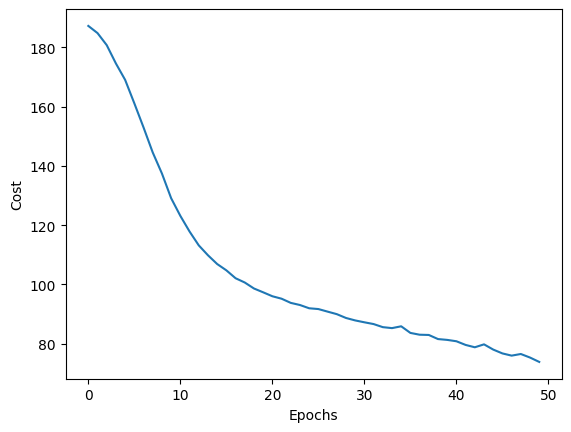

In [176]:
plt.plot(range(50), mlp.eval_['cost'])
plt.xlabel('Epochs')
plt.ylabel('Cost')

In [177]:
W = np.array([1,2,3,4,5,6,7,8,9,10])

L2_term = (0.01 * (np.sum(W ** 2.)))

L2_term


3.85